# LOADING DATA SET
The Universal Dependencies2 English Part-Of-Speech (UDPOS) benchmark was used for this task.

In [3]:
# !pip install torchtext==0.8.1

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

# import spacy
import numpy as np

import time
import random

TEXT = data.Field(lower = True)
UD_TAGS = data.Field(unk_token = None)
fields = (("text", TEXT), ("udtags", UD_TAGS))
train_data, valid_data, test_data = datasets.UDPOS.splits(fields)

def visualizeSentenceWithTags(example):
    print("Token"+"".join([" "]*(15))+"POS Tag")
    print("---------------------------------")
    
    for w, t in zip ( example ['text'], example ['udtags']):
        print(w+"". join ([" " ]*(20 - len (w)))+t)

/Users/johnnybui/opt/miniconda3/envs/torch-mps/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
visualizeSentenceWithTags(vars(train_data.examples[997]))

Token               POS Tag
---------------------------------
they                PRON
are                 AUX
doing               VERB
it                  PRON
deliberately        ADV
.                   PUNCT


# EXPLORE DATA

### What topic does the data cover?
The texts in the data seem to cover from macro topics such as economics and politics to daily life topics like service complaints.

In [5]:
import random

random.seed(99)

indices = random.sample(range(1, len(train_data.examples)), 10)

for i in indices:
    print("-", " ".join(vars(train_data.examples[i])['text']))

- your career opportunities will expand exponentially , and you 're likely to change jobs or positions this year .
- it 's certainly worth $ 6.00 and six stamps , and i have spent more than that on the lottery without ever winning !!!
- i have inserted the company details of uecomm as requested .
- rude , insensitive , discourteous people !!!!!
- thanks ,
- also , if you think of anything else i can do to strengthen my overall application file for next year , please let me know .
- please let me know if you are interested in any of these games .
- 11/08/2000 11:02 am
- # 2 ) if you take the shampoo products home , they will charge you $ 8 per item .
- the confidante and right - hand man of dr. ayman zawahiri admitted that zawahiri succeeded in obtaining anthrax and intended to use it against us targets .


### What text preprocessing would be (in)appropriate?
Appropriate: 
- lemmatization
- remove URLs

Inappropriate:
- lower casing: proper casing might give information about nouns
- removing stopwords: they provide valuable information about the surrounding words. For example, 'the' and 'a' are always followed by a noun phrase.
- removing punctuation: punctuations informs the model when the start and end of sentences.
- removing emojies and emoticons: don't affect the tags of surrounding words. For example, I love this song so much ❤️. I ❤️ this song so much (this might be helpful).

### Data Tag Distribution

In [7]:
count = {}
n_words = 0
vars(train_data.examples[1])['udtags']

for example in train_data.examples:
    n_words += len(vars(example)['text'])
    for tag in vars(example)['udtags']:
        if tag not in count.keys():
            count[tag] = 1
        else:
            count[tag] += 1

print(count)
print(n_words)
print(sum(count.values()))

{'PROPN': 12946, 'PUNCT': 23679, 'ADJ': 12477, 'NOUN': 34781, 'VERB': 23081, 'DET': 16285, 'ADP': 17638, 'AUX': 12343, 'PRON': 18577, 'PART': 5567, 'SCONJ': 3843, 'NUM': 3999, 'ADV': 10548, 'CCONJ': 6707, 'X': 847, 'INTJ': 688, 'SYM': 599}
204605
204605


['SYM', 'INTJ', 'X', 'SCONJ', 'NUM', 'PART', 'CCONJ', 'ADV', 'AUX', 'ADJ', 'PROPN', 'DET', 'ADP', 'PRON', 'VERB', 'PUNCT', 'NOUN']
[599, 688, 847, 3843, 3999, 5567, 6707, 10548, 12343, 12477, 12946, 16285, 17638, 18577, 23081, 23679, 34781]


Text(0, 0.5, 'Count')

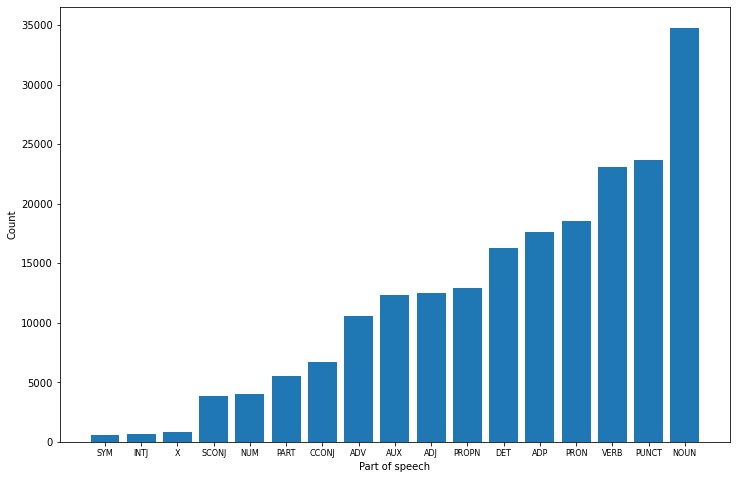

In [19]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'size'   : 8}

sorted_count = sorted(count.items(), key=lambda x:x[1])

# Using map for 0 index
keys = list(map(lambda x: x[0], sorted_count))
 
# Using map for 1 index
values = list(map(lambda x: x[1], sorted_count))

print(list(keys))
print(list(values))

y_pos = np.arange(len(list(keys)))

plt.figure(figsize=(12,8))
plt.bar(y_pos, values)
plt.xticks(y_pos, keys, **font)
plt.xlabel("Part of speech")
plt.ylabel("Count")

['PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADP', 'AUX', 'PRON', 'PART', 'SCONJ', 'NUM', 'ADV', 'CCONJ', 'X', 'INTJ', 'SYM']
[12946, 23679, 12477, 34781, 23081, 16285, 17638, 12343, 18577, 5567, 3843, 3999, 10548, 6707, 847, 688, 599]
688


Text(0, 0.5, 'Count')

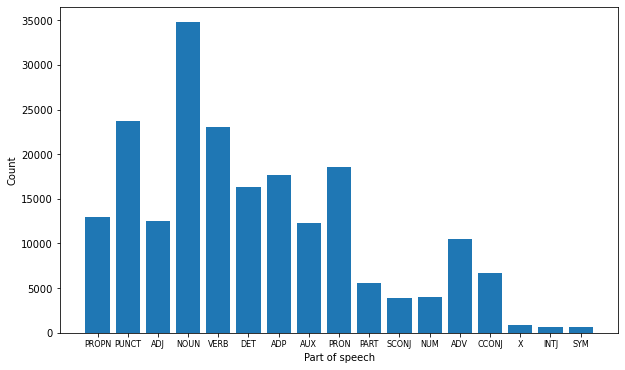

In [10]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'size'   : 8}

print(list(count.keys()))
print(list(count.values()))
print(count['INTJ'])
y_pos = np.arange(len(list(count.keys())))

plt.figure(figsize=(10,6))
plt.bar(y_pos, list(count.values()))
plt.xticks(y_pos, list(count.keys()), **font)
plt.xlabel("Part of speech")
plt.ylabel("Count")

Looks like there are more nouns than other parts of speech. 

In [19]:
count['NOUN'] / n_words

0.16999095818772758

# MODEL ARCHITECTURE
- Semantic Role Labelling?
- Dropout layer?
- BiLSTM?
- Gated Residual Connection?
- Autoregressive Language Models?
- Perplexity?
- 

# TRAINING

### Data Loader

In [20]:
MIN_FREQ = 2

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)


UD_TAGS.build_vocab(train_data)

In [23]:
BATCH_SIZE = 128

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = dev)

In [24]:
class BiLSTMPOSTagger(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        #pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        
        #outputs holds the backward and forward hidden states in the final layer
        #hidden and cell are the backward and forward hidden and cell states at the final time-step
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]
        
        #we use our outputs to make a prediction of what the tag should be
        predictions = self.fc(self.dropout(outputs))
        
        #predictions = [sent len, batch size, output dim]
        
        return predictions

In [25]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(UD_TAGS.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BiLSTMPOSTagger(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        BIDIRECTIONAL, 
                        DROPOUT, 
                        PAD_IDX)

In [26]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

BiLSTMPOSTagger(
  (embedding): Embedding(8866, 100, padding_idx=1)
  (lstm): LSTM(100, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=18, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,522,010 trainable parameters


In [28]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([8866, 100])


In [29]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.2413, -0.5423,  1.4786,  ..., -0.3262,  0.1403,  2.1207],
        [-0.7877,  0.4504,  0.8650,  ...,  1.6344,  0.1016, -0.5172],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.4977,  0.8511,  0.3970,  ...,  0.5901, -0.9220,  0.0835],
        [-0.5972,  0.0471, -0.2406,  ..., -0.9446, -0.1126, -0.2260],
        [-1.0683, -0.0369, -0.8427,  ..., -0.8793,  0.5355,  0.6441]])

In [30]:
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.2413, -0.5423,  1.4786,  ..., -0.3262,  0.1403,  2.1207],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.4977,  0.8511,  0.3970,  ...,  0.5901, -0.9220,  0.0835],
        [-0.5972,  0.0471, -0.2406,  ..., -0.9446, -0.1126, -0.2260],
        [-1.0683, -0.0369, -0.8427,  ..., -0.8793,  0.5355,  0.6441]])


In [31]:
optimizer = optim.Adam(model.parameters())
TAG_PAD_IDX = UD_TAGS.vocab.stoi[UD_TAGS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(dev)
criterion = criterion.to(dev)

In [32]:
def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

In [33]:
def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.udtags
        
        optimizer.zero_grad()
        
        #text = [sent len, batch size]
        
        predictions = model(text)
        
        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]
        
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        #predictions = [sent len * batch size, output dim]
        #tags = [sent len * batch size]
        
        loss = criterion(predictions, tags)
                
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [34]:
def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.udtags
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [35]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
N_EPOCHS = 3

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/var/folders/5_/w86z03f971n58jbfq5xgkc0r0000gn/T/ipykernel_91996/3869399929.py:6: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  non_pad_elements = (y != tag_pad_idx).nonzero()


Epoch: 01 | Epoch Time: 1m 40s
	Train Loss: 1.328 | Train Acc: 58.62%
	 Val. Loss: 0.683 |  Val. Acc: 78.39%
Epoch: 02 | Epoch Time: 1m 31s
	Train Loss: 0.483 | Train Acc: 84.77%
	 Val. Loss: 0.501 |  Val. Acc: 83.84%
Epoch: 03 | Epoch Time: 1m 32s
	Train Loss: 0.354 | Train Acc: 88.86%
	 Val. Loss: 0.444 |  Val. Acc: 85.16%


In [37]:
example_index = 1

sentence = vars(train_data.examples[example_index])['text']
actual_tags = vars(train_data.examples[example_index])['udtags']

print(sentence)

['[', 'this', 'killing', 'of', 'a', 'respected', 'cleric', 'will', 'be', 'causing', 'us', 'trouble', 'for', 'years', 'to', 'come', '.', ']']


In [43]:
import spacy
import en_core_web_sm

def tag_sentence(model, dev, sentence, text_field, tag_field):
    # Enter evaluation mode
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            nlp = spacy.load("en_core_web_sm")
            words = [word.text for word in nlp(sentence)]
            print(words)
        else:
            words = [word for word in sentence]

        if text_field.lower:
            words = [w.lower() for w in words]

        tokens = [text_field.vocab.stoi[t] for t in words]
        unk_idx = text_field.vocab.stoi[text_field.unk_token]
        unks = [t for t, n in zip(words, tokens) if n == unk_idx]
        token_tensor = torch.LongTensor(tokens)
        token_tensor = token_tensor.unsqueeze(-1).to(dev)

        preds = model(token_tensor)
        top_preds = preds.argmax(-1)

        pred_tags = [tag_field.vocab.itos[t.item()] for t in top_preds]
    
    return words, pred_tags, unks

for sentence in ["The old man the boat",
                "The man who hunts ducks out on weekends.",
                "The complex houses married and single soldiers and their families."]:

    words, pred_tags, unks = tag_sentence(model, 
                                        dev, 
                                        sentence,
                                        TEXT, 
                                        UD_TAGS)

    print("%10s%10s\n" % ('word','pred_tag'))

    for word, pred_tag in zip(words, pred_tags):
        print("%10s%10s" % (word,pred_tag))

['The', 'old', 'man', 'the', 'boat']
      word  pred_tag

       the       DET
       old       ADJ
       man      NOUN
       the       DET
      boat      NOUN
['The', 'man', 'who', 'hunts', 'ducks', 'out', 'on', 'weekends', '.']
      word  pred_tag

       the       DET
       man      NOUN
       who      PRON
     hunts      VERB
     ducks      VERB
       out       ADP
        on       ADP
  weekends      NOUN
         .     PUNCT
['The', 'complex', 'houses', 'married', 'and', 'single', 'soldiers', 'and', 'their', 'families', '.']
      word  pred_tag

       the       DET
   complex       ADJ
    houses      NOUN
   married      VERB
       and     CCONJ
    single       ADJ
  soldiers      NOUN
       and     CCONJ
     their      PRON
  families      NOUN
         .     PUNCT


In [39]:
print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

DET		PUNCT		✘		the
ADJ		DET		✘		old
NOUN		NOUN		✔		man
DET		ADP		✘		the
NOUN		DET		✘		boat
